       UpProb_Shift_1  UpProb_Shift_2  UpProb_Shift_3  UpProb_Shift_4  \
count   534138.000000   534138.000000   534138.000000   534138.000000   
mean         0.480675        0.479315        0.480215        0.481355   
std          0.107529        0.074594        0.052083        0.050730   
min          0.006145        0.020942        0.004376        0.001559   
25%          0.442719        0.446556        0.457180        0.457193   
50%          0.486789        0.486293        0.486751        0.488100   
75%          0.523034        0.515615        0.510589        0.512571   
max          0.873065        0.774164        0.721274        0.709275   

       UpProb_Shift_5   price_change  
count   534138.000000  534138.000000  
mean         0.480716       0.006459  
std          0.050029       0.836333  
min          0.000959      -0.983333  
25%          0.455532      -0.038298  
50%          0.486951       0.000000  
75%          0.511698       0.037037  
max          0.693856     283.

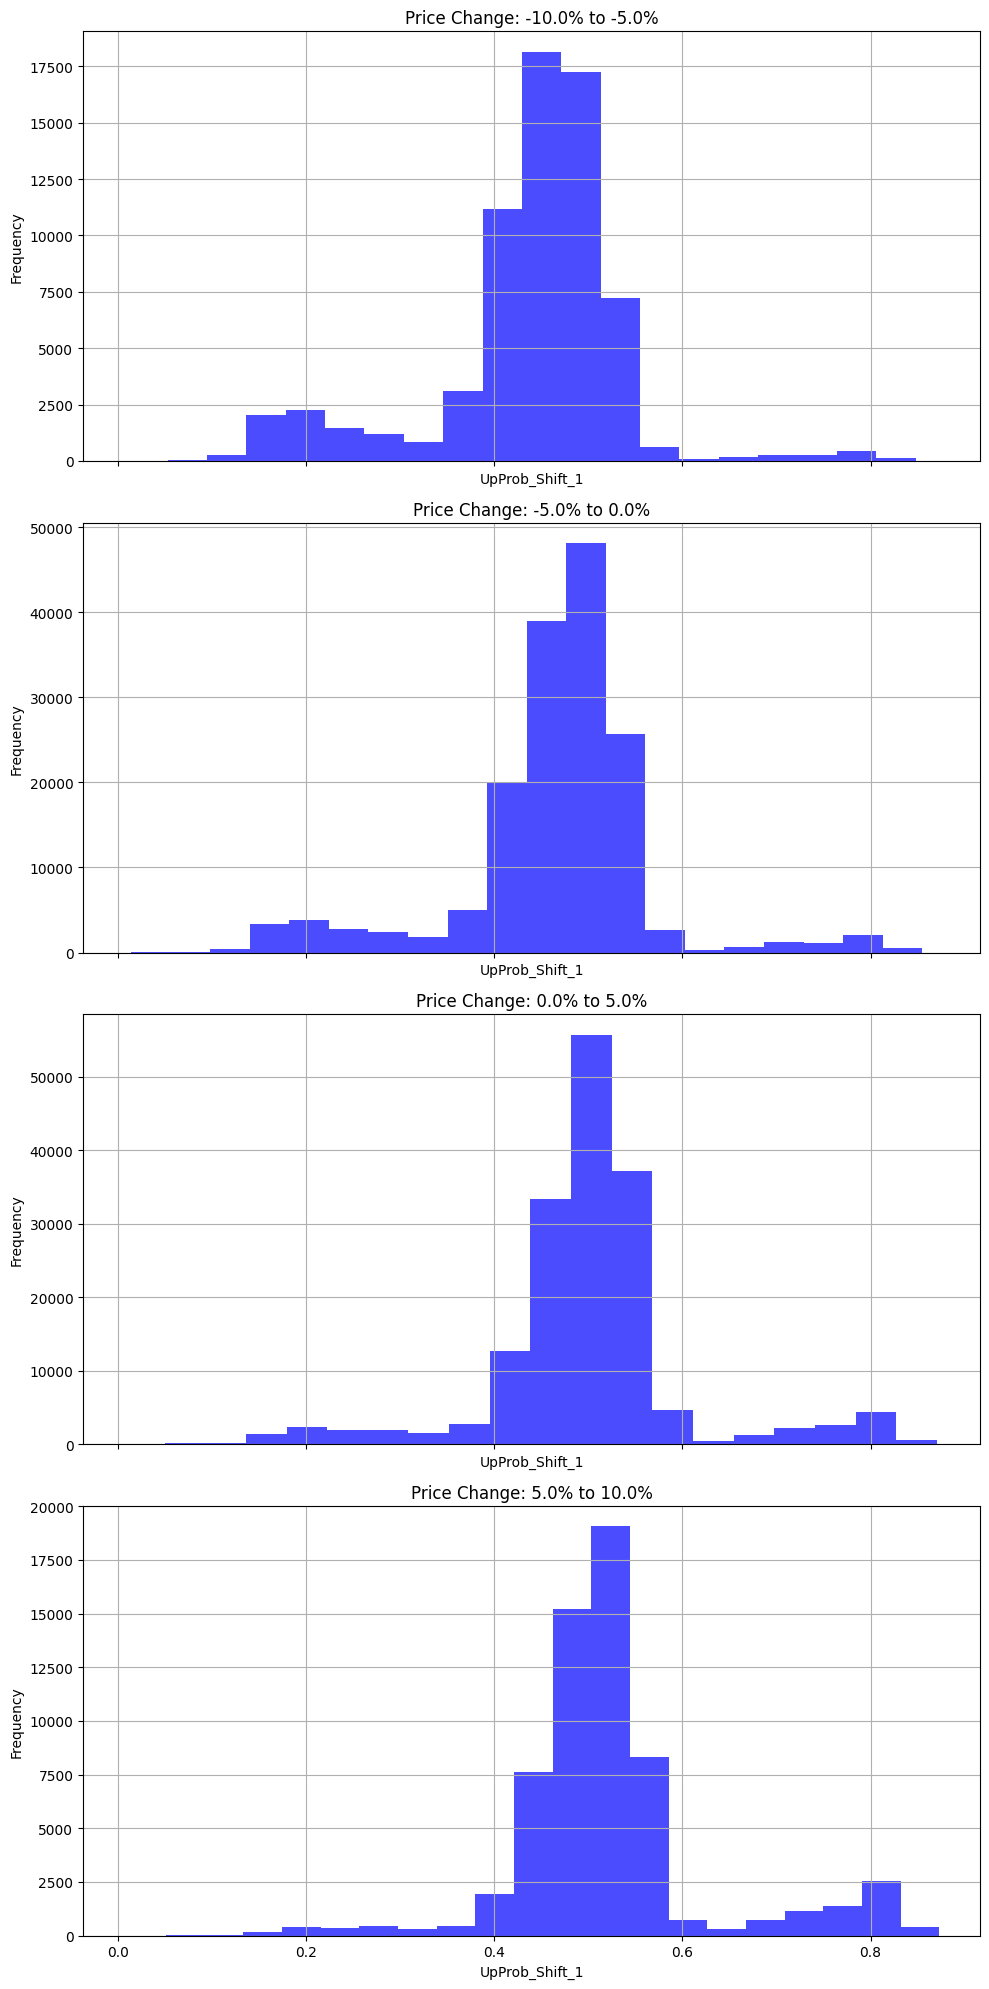

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def identify_significant_moves(df, price_col='Close', look_forward=5):
    """ This function now simply calculates future prices and changes without applying a threshold. """
    df['future_price'] = df[price_col].shift(-look_forward)
    df['price_change'] = (df['future_price'] - df[price_col]) / df[price_col]
    return df

def extract_pre_move_conditions(df, probability_columns, days_before=1):
    """ Modified to return price changes along with probabilities. """
    move_indices = df.index[(abs(df['price_change']) > 0.01)].tolist()  # Example threshold for visualization
    pre_move_stats = []
    for idx in move_indices:
        pre_move_idx = idx - days_before
        if pre_move_idx > 0:
            conditions = df.loc[pre_move_idx, probability_columns + ['price_change']]
            pre_move_stats.append(conditions)
    return pd.DataFrame(pre_move_stats)

def process_files(directory_path):
    all_pre_move_conditions = []
    files = os.listdir(directory_path)
    for file_name in files:
        if file_name.endswith('.csv'):
            df = pd.read_csv(os.path.join(directory_path, file_name))
            df['Date'] = pd.to_datetime(df['Date'])
            df = identify_significant_moves(df, 'Close')
            probability_columns = [col for col in df.columns if 'UpProb_Shift' in col]
            pre_move_conditions = extract_pre_move_conditions(df, probability_columns)
            all_pre_move_conditions.append(pre_move_conditions)
    if all_pre_move_conditions:
        combined_pre_move_conditions = pd.concat(all_pre_move_conditions, ignore_index=True)
        return combined_pre_move_conditions
    else:
        return pd.DataFrame()  # Return empty DataFrame if no data

# Example usage
directory_path = 'Data/RFpredictions'
combined_pre_move_conditions = process_files(directory_path)
if not combined_pre_move_conditions.empty:
    print(combined_pre_move_conditions.describe())
else:
    print("No significant moves found or no data available.")





def plot_probability_distribution(data, bin_width=0.05):
    """ Plots histograms of UpProb values segmented by price change intervals. """
    intervals = np.arange(-0.1, 0.11, bin_width)
    fig, axes = plt.subplots(nrows=len(intervals)-1, figsize=(10, 20), sharex=True)

    for i in range(len(intervals)-1):
        lower = intervals[i]
        upper = intervals[i+1]
        subset = data[(data['price_change'] >= lower) & (data['price_change'] < upper)]
        ax = axes[i]
        subset['UpProb_Shift_1'].hist(ax=ax, bins=20, alpha=0.7, color='blue')
        ax.set_title(f"Price Change: {lower*100:.1f}% to {upper*100:.1f}%")
        ax.set_xlabel('UpProb_Shift_1')
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_probability_distribution(combined_pre_move_conditions)
